### Обучение на NewsAggrregatorKaggleFN
Тестирование на Fake and real news dataset

In [ ]:
import tensorflow as tf
import os
import numpy as np
import random

SEED = 42

In [ ]:
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [ ]:
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.7 MB/s eta 0:00:00


In [ ]:
import re
import nltk
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import auc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from transformers import RobertaTokenizer
from sklearn.metrics import roc_curve, confusion_matrix,auc, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
news_data = pd.read_csv('/content/drive/MyDrive/Data/NewsAgreggatorKaggleFNforBERT.csv')
news_data.head()

,title,label
0,supply demand chain executive oil falls to aro...,0
1,london south east major averages climb off low...,0
2,gabrielle cintorino new poll shows support for...,1
3,artist s impression of the clinton machine rus...,1
4,worcester telegram s p gains on global growth ...,0


In [ ]:
print(news_data['title'])

0        supply demand chain executive oil falls to aro...
1        london south east major averages climb off low...
2        gabrielle cintorino new poll shows support for...
3        artist s impression of the clinton machine rus...
4        worcester telegram s p gains on global growth ...
                               ...                        
24633    qfinance com global markets world stocks coppe...
24634    david gutierrez staff writer why hydrogen pero...
24635    bay news spacex preps falcon rocket for pre da...
24636    law subscription jos a bank men s wearhouse in...
24637    hillary clinton laundered isis cash says inves...
Name: title, Length: 24638, dtype: object


In [ ]:
news_data.isnull().sum()

title    180
label      0
dtype: int64

In [ ]:
news_data = news_data.dropna()

In [ ]:
news_data.isnull().sum()

title    0
label    0
dtype: int64

In [ ]:
#separating the data and label
X = news_data['title'].values
Y = news_data['label'].values

In [ ]:
print(X)

['supply demand chain executive oil falls to around after china japan data'
 'london south east major averages climb off lows but remain in the red'
 'gabrielle cintorino new poll shows support for police officers is on the rise cop haters will be furious'
 ... 'bay news spacex preps falcon rocket for pre dawn launch sunday'
 'law subscription jos a bank men s wearhouse ink b merger deal'
 'hillary clinton laundered isis cash says investigating u s army officer']


In [ ]:
print(Y)

[0 0 1 ... 0 0 1]


In [ ]:
EPOCHS=2
max_seq_length = 60
LEARNING_RATE=1e-5
early_stopping=early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
def bert_encode(data, max_len) :
    input_ids = [] 
    attention_masks = []
    
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
# # First load the real tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

### Fine-tuning Model

In [ ]:
from transformers import TFRobertaModel

In [ ]:
bert_layers = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

train_input_ids, train_attention_masks = bert_encode(X_train, 60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
def build_model(transformer_layer,max_len=max_seq_length):
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32',name='attention_masks')

    output = bert_layers([input_ids,attention_masks])
    output = output[1]
    net = tf.keras.layers.Dense(32,activation='relu')(output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
    outputs = net
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = outputs)
    
    
    return model

In [ ]:
def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('RoBERTa')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
METRICS = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc')]

In [ ]:
model = build_model(bert_layers, max_len=max_seq_length)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=METRICS)

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    Y_train,
    validation_split=0.2, 
    epochs=2,
    batch_size=32)

Epoch 1/2
490/490 [==============================] - 290s 484ms/step - loss: 0.2169 - tp: 7023.0000 - fp: 695.0000 - tn: 7182.0000 - fn: 752.0000 - accuracy: 0.9076 - precision: 0.9100 - recall: 0.9033 - auc: 0.9713 - val_loss: 0.0757 - val_tp: 1868.0000 - val_fp: 33.0000 - val_tn: 1945.0000 - val_fn: 68.0000 - val_accuracy: 0.9742 - val_precision: 0.9826 - val_recall: 0.9649 - val_auc: 0.9957
Epoch 2/2
490/490 [==============================] - 213s 436ms/step - loss: 0.0688 - tp: 7590.0000 - fp: 190.0000 - tn: 7687.0000 - fn: 185.0000 - accuracy: 0.9760 - precision: 0.9756 - recall: 0.9762 - auc: 0.9963 - val_loss: 0.0554 - val_tp: 1900.0000 - val_fp: 31.0000 - val_tn: 1947.0000 - val_fn: 36.0000 - val_accuracy: 0.9829 - val_precision: 0.9839 - val_recall: 0.9814 - val_auc: 0.9963


In [ ]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 21s 136ms/step - loss: 0.0528 - tp: 2396.0000 - fp: 49.0000 - tn: 2415.0000 - fn: 32.0000 - accuracy: 0.9834 - precision: 0.9800 - recall: 0.9868 - auc: 0.9972


In [ ]:
print(f'RoBERTa accuracy: {score[5]}')

BERT accuracy: 0.9834423661231995


In [ ]:
y_predict_prob=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 20s 132ms/step


In [ ]:
print(classification_report(Y_test,  np.round(y_predict_prob)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2464
           1       0.98      0.99      0.98      2428

    accuracy                           0.98      4892
   macro avg       0.98      0.98      0.98      4892
weighted avg       0.98      0.98      0.98      4892



In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
print('RoBERTa: ROC AUC=%.4f' % roc_auc_score(Y_test, y_predict_prob))

RoBERTa: ROC AUC=0.9983


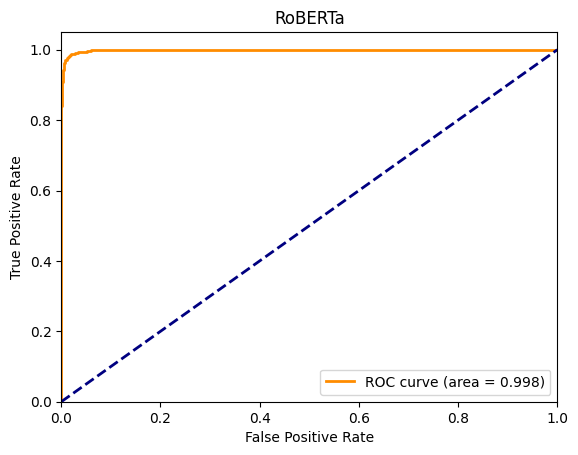

In [ ]:
fpr, tpr, _ = roc_curve(Y_test, y_predict_prob)
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc)

**Testing: Fake and real news dataset**

In [ ]:
news_test = pd.read_csv('/content/drive/MyDrive/Data/FNDatasetBERT.csv')

In [ ]:
x_test = news_test['title'].values
y_test = news_test['label'].values

In [ ]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 189s 135ms/step - loss: 1.3897 - tp: 22941.0000 - fp: 12457.0000 - tn: 8960.0000 - fn: 540.0000 - accuracy: 0.7105 - precision: 0.6481 - recall: 0.9770 - auc: 0.8452


In [ ]:
print(f'RoBERTa accuracy FNDataset: {score[5]}')

RoBERTa accuracy FNDataset: 0.7105216383934021


In [ ]:
model.save('/content/drive/MyDrive/Models/FINAL/ROBERTA.h5')

### Training Classifier

In [ ]:
bert_layers = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
model = build_model(bert_layers, max_len=max_seq_length)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=METRICS)

In [ ]:
model.layers[2].trainable = False

In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    Y_train,
    validation_split=0.2, 
    epochs=2,
    batch_size=32)

Epoch 1/2
490/490 [==============================] - 280s 469ms/step - loss: 0.2213 - tp: 29933.0000 - fp: 13155.0000 - tn: 16139.0000 - fn: 1323.0000 - accuracy: 0.7609 - precision: 0.6947 - recall: 0.9577 - auc: 0.8468 - val_loss: 0.0759 - val_tp: 1877.0000 - val_fp: 40.0000 - val_tn: 1938.0000 - val_fn: 59.0000 - val_accuracy: 0.9747 - val_precision: 0.9791 - val_recall: 0.9695 - val_auc: 0.9960
Epoch 2/2
490/490 [==============================] - 205s 418ms/step - loss: 0.0668 - tp: 7587.0000 - fp: 164.0000 - tn: 7713.0000 - fn: 188.0000 - accuracy: 0.9775 - precision: 0.9788 - recall: 0.9758 - auc: 0.9965 - val_loss: 0.0621 - val_tp: 1907.0000 - val_fp: 49.0000 - val_tn: 1929.0000 - val_fn: 29.0000 - val_accuracy: 0.9801 - val_precision: 0.9749 - val_recall: 0.9850 - val_auc: 0.9963


In [ ]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

In [ ]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 20s 133ms/step - loss: 0.0615 - tp: 2403.0000 - fp: 81.0000 - tn: 2383.0000 - fn: 25.0000 - accuracy: 0.9783 - precision: 0.9674 - recall: 0.9897 - auc: 0.9972


In [ ]:
print(f'RoBERTa accuracy: {score[5]}')

RoBERTa accuracy: 0.978331983089447


In [ ]:
y_predict_prob=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 24s 132ms/step


In [ ]:
print(classification_report(Y_test,  np.round(y_predict_prob)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2464
           1       0.97      0.99      0.98      2428

    accuracy                           0.98      4892
   macro avg       0.98      0.98      0.98      4892
weighted avg       0.98      0.98      0.98      4892



In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
print('RoBERTa: ROC AUC=%.4f' % roc_auc_score(Y_test, y_predict_prob))

RoBERTa: ROC AUC=0.9983


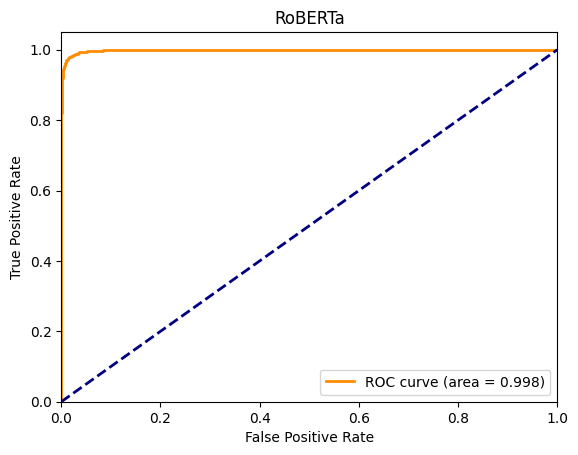

In [ ]:
fpr, tpr, _ = roc_curve(Y_test, y_predict_prob)
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc)

**Testing: Fake and real news dataset**

In [ ]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 190s 135ms/step - loss: 1.1422 - tp: 23161.0000 - fp: 11399.0000 - tn: 10018.0000 - fn: 320.0000 - accuracy: 0.7390 - precision: 0.6702 - recall: 0.9864 - auc: 0.8789


In [ ]:
print(f'RoBERTa accuracy FNDataset: {score[5]}')

RoBERTa accuracy FNDataset: 0.7389861345291138


In [ ]:
model.save('/content/drive/MyDrive/Models/FINAL/ROBERTA_freezed_2.h5')